LOAD PACKAGES

In [6]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
import rpy2 
from matplotlib.backends.backend_pdf import PdfPages
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


LOAD FUNCTIONS 

In [13]:
def sample_mutationrates(row):
    result=[]
    generation_length = row['GENERATION_LENGTH']
    for i in range(10000):
        result.append(random.choice(alphas['alpha'])+random.choice(betas["beta"])*np.log10(generation_length)) ##ADJUST FOR IMPORTING ALPHAS AND BETAS
    return result
    
def calculate_mean_and_variance(row):
    values_list = row['estimated_mutation_rates']
    mean_value = np.mean(values_list)
    variance_value = np.var(values_list)
    median = np.median(values_list)
    return pd.Series({'MEAN': mean_value, 'VARIANCE': variance_value, 'MEDIAN': median})

def calculate_NE_mean_and_variance(row):
    values_list = row['Ne']
    mean_value = np.mean(values_list)
    variance_value = np.var(values_list)
    median = np.median(values_list)
    return pd.Series({'NE_MEAN': mean_value, 'NE_VARIANCE': variance_value, 'NE_MEDIAN': median})

def calculate_90_ci(row):
    values_list = row['Ne']
    lower_bound, upper_bound = np.percentile(values_list, [5, 95])
    return pd.Series({'lower_bound': lower_bound, 'upper_bound': upper_bound})

def sample_Nes(row):
    Nes = []
    values_list = row['estimated_mutation_rates']
    pi = row['max']
    for value in values_list:
        Ne = pi/(4*value)
        Nes.append(Ne)
    return pd.Series({'Ne': Nes})

READ IN DATA

In [8]:
alphas = pd.read_csv('../results/model/Ne_models/alphas.csv')
betas = pd.read_csv('../results/model/Ne_models/betas.csv')

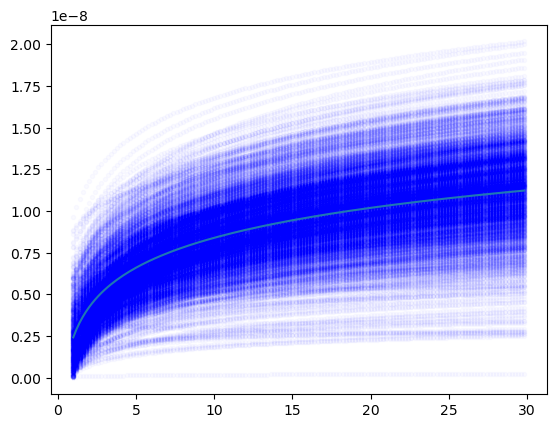

In [36]:
sample = 1000
matrix = [[] for i in range(1000)]
for i in range(sample):
    matrix[i]=[]
    alpha = random.choice(alphas['alpha'])
    beta = random.choice(betas['beta'])
    for j in np.arange(1,30,0.2):
        matrix[i].append(alpha+beta*np.log10(j))
sampled_points=np.array(matrix)

x= np.arange(1,30,0.2)
for i in range(1000):
    y=sampled_points[i]
    plt.plot(x, y, 'b.',alpha=0.02);
plt.plot(x, alphas['alpha'].mean() + betas['beta'].mean() * np.log10(x))

In [9]:
generation_times = pd.read_csv('../data/Kuderna_et_al_2023.csv')
highest_pi = pd.read_csv('../results/pi_in_five_percent.csv')

In [10]:
highest_pi

,genus,species,max
0,Allenopithecus,nigroviridis,0.001620
1,Allochrocebus,lhoesti,0.002780
2,Allochrocebus,preussi,0.003050
3,Allochrocebus,solatus,0.003395
4,Alouatta,belzebul,0.001923
...,...,...,...
189,Trachypithecus,melamera,0.001252
190,Trachypithecus,phayrei,0.000751
191,Trachypithecus,pileatus,0.001370
192,Varecia,rubra,0.001308


MERGE DATASET

In [11]:
generation_times = generation_times[['GENUS','SPECIES','FAMILY','GENERATION_LENGTH']]
merged_df = pd.merge(highest_pi, generation_times, how='inner', left_on=['genus','species'], right_on=['GENUS','SPECIES'])

In [12]:
merged_df

,genus,species,max,GENUS,SPECIES,FAMILY,GENERATION_LENGTH
0,Allenopithecus,nigroviridis,0.001620,Allenopithecus,nigroviridis,Cercopithecidae,10.0
1,Allochrocebus,lhoesti,0.002780,Allochrocebus,lhoesti,Cercopithecidae,10.0
2,Allochrocebus,preussi,0.003050,Allochrocebus,preussi,Cercopithecidae,10.0
3,Allochrocebus,solatus,0.003395,Allochrocebus,solatus,Cercopithecidae,10.0
4,Alouatta,belzebul,0.001923,Alouatta,belzebul,Atelidae,12.0
...,...,...,...,...,...,...,...
182,Trachypithecus,melamera,0.001252,Trachypithecus,melamera,Cercopithecidae,12.0
183,Trachypithecus,phayrei,0.000751,Trachypithecus,phayrei,Cercopithecidae,12.0
184,Trachypithecus,pileatus,0.001370,Trachypithecus,pileatus,Cercopithecidae,12.0
185,Varecia,rubra,0.001308,Varecia,rubra,Lemuridae,8.0


DRAW ESTIMATS OF MUTATION RATES FOR EACH SPECIES GENERATIONTIME

In [14]:
merged_df['estimated_mutation_rates'] = merged_df.apply(sample_mutationrates,axis=1) 

Plotting the distribution of mutationrates 

In [19]:
with PdfPages('../figures/mutation_rates_histograms.pdf') as pdf:
    # Plotting histograms for each species and saving them in the PDF
    for index, row in merged_df.iterrows():
        plt.figure(figsize=(8, 5))
        plt.hist(row['estimated_mutation_rates'], bins=30, alpha=0.7, color='blue', edgecolor='black')
        plt.title(f'Histogram for {row["species"]} Estimated Mutation Rates')
        plt.xlabel('Estimated Mutation Rates')
        plt.ylabel('Frequency')
        plt.grid(True)
        pdf.savefig()
        plt.close()

ESTIMATE MEAN AND VARIANCE FOR THE MUTATION RATES

In [15]:
# Apply the second function to each row and store the result in new columns
merged_df[['MEAN', 'VARIANCE', 'MEDIAN']] = merged_df.apply(calculate_mean_and_variance, axis=1)

SAMPLE NES FROM THE MUTATION RATES

In [16]:
merged_df[['Ne']] = merged_df.apply(sample_Nes, axis=1)

PLOTTING THE DISTRIBUTIONS OF NEs

In [20]:
with PdfPages('../figures/Ne_histograms.pdf') as pdf:
    # Plotting histograms for each species and saving them in the PDF
    for index, row in merged_df.iterrows():
        plt.figure(figsize=(8, 5))
        plt.hist(row['Ne'], bins=3000, alpha=0.7, color='blue', edgecolor='black')
        plt.title(f'Histogram for {row["species"]} Estimated effective population sizes')
        plt.xlabel('Estimated effective population sizes')
        plt.ylabel('Frequency')
        plt.grid(True)
        pdf.savefig()
        plt.close()

ESTIMATE MEAN AND VARIANCE AND 90% CONFIDENCE INTERVAL 

In [25]:
merged_df[['NE_MEAN', 'NE_VARIANCE', 'NE_MEDIAN']] = merged_df.apply(calculate_NE_mean_and_variance, axis=1)
merged_df[['lower_bound', 'upper_bound']] = merged_df.apply(calculate_90_ci, axis=1)

EXPORT DATA FRAME

In [27]:
merged_df[['genus','species','FAMILY','MEAN','MEDIAN','VARIANCE','NE_MEAN','NE_MEDIAN','NE_VARIANCE']].to_csv('../results/model/Nested_model/Ne_Pi_recomb.csv')

In [28]:
merged_df

,genus,species,max,GENUS,SPECIES,FAMILY,GENERATION_LENGTH,estimated_mutation_rates,MEAN,VARIANCE,MEDIAN,Ne,NE_MEAN,NE_VARIANCE,NE_MEDIAN,lower_bound,upper_bound
0,Allenopithecus,nigroviridis,0.001620,Allenopithecus,nigroviridis,Cercopithecidae,10.0,"[1.1577614912390637e-08, 1.0809428617453721e-0...",8.357479e-09,5.094145e-18,8.297569e-09,"[34986.178419561526, 37472.51731176985, 35883....",52454.392022,6.495222e+09,48795.239046,33276.160919,85020.858724
1,Allochrocebus,lhoesti,0.002780,Allochrocebus,lhoesti,Cercopithecidae,10.0,"[6.146920078488209e-09, 9.677877194634615e-09,...",8.402222e-09,5.101718e-18,8.346570e-09,"[113073.41207167499, 71818.76903665252, 52187....",91522.612916,3.229879e+10,83265.948886,56870.814433,146562.067432
2,Allochrocebus,preussi,0.003050,Allochrocebus,preussi,Cercopithecidae,10.0,"[8.465981100065263e-09, 5.719442126668908e-09,...",8.381493e-09,5.056495e-18,8.317710e-09,"[90052.21598243326, 133296.27988915367, 78135....",98961.872671,6.145338e+09,91643.614927,62443.115131,160472.245144
3,Allochrocebus,solatus,0.003395,Allochrocebus,solatus,Cercopithecidae,10.0,"[9.775335032781673e-09, 7.82707618939933e-09, ...",8.396774e-09,4.931361e-18,8.358020e-09,"[86822.50692249043, 108433.73349333435, 74501....",110522.354754,3.179448e+09,101523.498324,69986.074252,175544.277856
4,Alouatta,belzebul,0.001923,Alouatta,belzebul,Atelidae,12.0,"[1.1803392663143343e-08, 8.444908933084471e-09...",8.841273e-09,5.566924e-18,8.806322e-09,"[40719.62285070285, 56913.54417322317, 92145.4...",59405.700850,3.334359e+09,54569.554211,37568.439153,97057.847365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Trachypithecus,melamera,0.001252,Trachypithecus,melamera,Cercopithecidae,12.0,"[9.267476237136855e-09, 7.2360099435241445e-09...",8.872274e-09,5.561180e-18,8.842806e-09,"[33773.32901513842, 43254.98811356845, 31423.4...",45550.929003,3.934481e+11,35385.183757,24451.336291,61717.859104
183,Trachypithecus,phayrei,0.000751,Trachypithecus,phayrei,Cercopithecidae,12.0,"[9.644851436992606e-09, 7.296720636438616e-09,...",8.886826e-09,5.460429e-18,8.861310e-09,"[19477.71861622979, 25745.77152466839, 16486.4...",20253.268312,8.768754e+10,21198.124201,14720.172469,37110.878227
184,Trachypithecus,pileatus,0.001370,Trachypithecus,pileatus,Cercopithecidae,12.0,"[5.882033707471406e-09, 8.67497496359778e-09, ...",8.884702e-09,5.603345e-18,8.871295e-09,"[58247.352144448, 39494.3950988082, 32841.1296...",42453.240463,2.388481e+09,38613.452937,26762.146364,67867.060287
185,Varecia,rubra,0.001308,Varecia,rubra,Lemuridae,8.0,"[8.986754678431159e-09, 7.438258833689769e-09,...",7.840830e-09,4.665695e-18,7.735345e-09,"[36382.57397851083, 43956.69392867308, 48297.5...",45401.300726,1.710427e+09,42253.192246,28371.476054,73844.900502
